<a href="https://colab.research.google.com/github/Lilol/DeepLearningHw/blob/main/CNN_vs_ViT_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning for cloud-image categorization
## Comparing Vision Transformer and CNN rchitectures

## 1.) Data preprocessing

This section of the code:
* Downloads the Swimcat-extend dataset
* Defines basic parameters (image size, batch size)
* Prepars the dataset for processing by reading the entire set and labels into the memory

In [1]:
# Dependencies
!pip install patool -q
!pip install pyunpack -q
!pip install tensorflow -q
!pip install tensorboard -q
!pip install lime -q
!pip install sklearn -q
!pip install tfimm -q
!pip install timm -q
!pip install keras-flops -q
!pip install torch -q

     |████████████████████████████████| 77 kB 2.2 MB/s 
     |████████████████████████████████| 275 kB 17.3 MB/s 
     |████████████████████████████████| 155 kB 34.1 MB/s 
     |████████████████████████████████| 549 kB 33.1 MB/s 
     |████████████████████████████████| 182 kB 45.3 MB/s 


In [2]:
%load_ext tensorboard

In [3]:
import numpy as np
from os.path import join
import tensorflow as tf
import tensorboard as tb
import pandas as pd

In [4]:
# Google Drive is used for logging and storing data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
log_dir = join("drive", "MyDrive", "checkpoints")

### Download and unzip dataset

The dataset ("Swimcat-extend") contains 6 cloud categories, each in their corresponding directory.
There are 2100 images in total, 350 in each category.

In [ ]:
from pyunpack import Archive
from os.path import isdir
from os import remove
from shutil import rmtree
import patoolib
from urllib import request

# Download the Swimcat-extend dataset, and unzip it
def download_and_unzip_images(target_directory):
    inner_dir = join(target_directory, "Swimcat-extend")
    if isdir(inner_dir):
      rmtree(inner_dir)
    url = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/vwdd9grvdp-2.zip'
    zip_file = join(target_directory, "images.zip")
    file_handle, _ = request.urlretrieve(url, zip_file)
    Archive(zip_file).extractall(target_directory)
    rar_file = join(target_directory, "Cloud-ImVN 1.0.rar")
    patoolib.extract_archive(rar_file, outdir=target_directory)
    remove(zip_file)
    remove(rar_file)
    return inner_dir

In [6]:
# Download data, or load input dir
from numpy.random import seed
from os import makedirs

download = False

input_location = "drive/MyDrive/input"
makedirs(input_location, exist_ok=True)

if download:
  input_location = download_and_unzip_images(input_location)
else:
  input_location = join(input_location, "Swimcat-extend")

### Define parameters for the training

Image height and width are given for the pre-trained networks used later in the document.
Batch size was expreimentally set.

In [7]:
batch_size = 64
img_height = 224
img_width = 224
IMAGE_SHAPE = (img_height, img_width)

seed = 10
tf.keras.utils.set_random_seed(
    seed
)

### Read the dataset from disk

In [8]:
training_set = tf.keras.utils.image_dataset_from_directory(
    input_location,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=IMAGE_SHAPE,
    shuffle=False
)

Found 2100 files belonging to 6 classes.


In [9]:
# Training labels
class_names = training_set.class_names
num_classes = len(class_names)
class_names

['A-Clear Sky',
 'B-Patterned Clouds',
 'C-Thin White Clouds',
 'D-Thick White Clouds',
 'E-Thick Dark Clouds',
 'F-Veil Clouds']

### Create a unified dataset for K-fold cross-validation

All models are evaludated using K-fold cross-validation.
For the validation, the dataset is not split into separate training and validation sets, but stored as a unified array in the memory.

In [ ]:
inputs = np.concatenate(list(training_set.map(lambda x, y:x)))
targets = np.concatenate(list(training_set.map(lambda x, y:y)))

indices = np.arange(inputs.shape[0])
np.random.shuffle(indices)

inputs = inputs[indices]
targets = targets[indices]

del training_set
del indices

## 2.) Model definitions

This section of the code:
* Builds the network models using pre-trained PyTorch models (from the timmf library) to compare the architectures
* Adds additional layers for preprocessing
* Defines the models used


### Hyperparameters

Four hyperparameter classes with the following value sets are defined.

1.) Network type: 
* CNN
* ViT

2.) Network size: 5 or 10 million parameters

3.) Augmentation: 
* no augmentation (*na*)
* light augmentation (*la*): Using only a random rotation layer.
* high augmentation (*ha*): Using random rotation, flip and zoom layers.

4.) Trainabiliy:
* Only an additionaly dense layer is trainable on top of the frozen model
* The entire pre-trained model is trainable


### Experimental setup

We defined 5 experiments with distinct hyperparameter-configurations to analyse the effects of the parameter values on the accuracy.

**Analyzing the effects of data augmentation:**

**1.)** Small (5M) network with no augmentation

**2.)** Small network with light augmentation

**3.)** Small network with high augmentation

**Analyzing the effects of trainable parameter count:**

**4.)** Small network with high augmentation and trainable weights

**Analyzing the effects of network size:**

**5.)** Large (10M) network with high augmentation and trainable weights


The experiment configurations were evaluated for both CNN and ViT architectures, as summarized in the following table.

#### Summary

| **Parameter count** | **Trainable** | **Augmentation** |   **CNN**   |   **ViT**   |
|---------------------|----------------|------------------|:-----------:|:-----------:|
|             |                |       none       | cnn_5m_f_na | vit_5m_f_na |
|    **$5e6$**                  |        no     |        low       | cnn_5m_f_la | vit_5m_f_la |
|                     |                |       high       | cnn_5m_f_ha | vit_5m_f_ha |
| **5e6**             |       yes       |   high  |  cnn_5m_t |  vit_5m_t |
| **1e7**            |       no      |   high  | cnn_10m_f | vit_10m_f |


#### Other parameters

Learning rate, epoch count, optimizer and the parameters of the augmentation layers were tuned experimentally.

* learning rate: $3e-5$
* max epoch count: 400
* patience (early stopping): 20 epochs
* optimizer: Adam

In [10]:
from tensorboard.plugins.hparams import api as hp

# Define hyperparameters and their scope for the experiments
HP_AUGMENTATION = hp.HParam('augmentation', hp.Discrete(["none", "low", "high"]))
HP_NETWORK_SIZE = hp.HParam('network_size', hp.Discrete([5, 10]))
HP_NETWORK_TYPE = hp.HParam('network_type', hp.Discrete(['cnn', 'vit']))
HP_INNER_LAYERS_TRAINABLE = hp.HParam('inner_layers_trainable', hp.Discrete(['trainable', 'frozen']))

METRIC_ACCURACY = 'accuracy'
METRIC_LOSS = 'loss'

def hyperparams_from_model_name(model_name):
  parameters = model_name.split('_')
  assert len(parameters) == 4
  augmentation = {"ha": "high", "la": "low", "na": "none"}
  hparams = {
          HP_NETWORK_TYPE: parameters[0],  # cnn or vit
          HP_NETWORK_SIZE: int(parameters[1].strip("m")),  # 5 or 10 M
          HP_INNER_LAYERS_TRAINABLE: 'frozen' if parameters[3] == "f" else "trainable",
          HP_AUGMENTATION: augmentation[parameters[2]]
      }
  return hparams


models = ["vit_5m_la_f", "vit_5m_na_f", "vit_5m_ha_f", "vit_5m_ha_t", "vit_10m_ha_t",
          "cnn_5m_na_f", "cnn_5m_la_f", "cnn_5m_ha_f", "cnn_5m_ha_t", "cnn_10m_ha_t"]
model_hyperparams = {model: hyperparams_from_model_name(model) for model in models}

### Download the feature model without the top layer.
Freeze weights if necessary.

In [11]:
import warnings
warnings.filterwarnings("ignore")
import tfimm

# Download the feature model without the top layer.
# Freeze weights if necessary.
def download_feature_extractor_layer(hparams):
  if hparams[HP_NETWORK_TYPE] == "vit":
    if hparams[HP_NETWORK_SIZE] == 5:
      name = "vit_tiny_patch16_224"
    if hparams[HP_NETWORK_SIZE] == 10:
      name = "vit_tiny_r_s16_p8_224_in21k"

  if hparams[HP_NETWORK_TYPE] == "cnn":
    if hparams[HP_NETWORK_SIZE] == 5:
      name = "efficientnet_b1"
    if hparams[HP_NETWORK_SIZE] == 10:
      name = "resnet18d"
      
  feature_extractor_layer = tfimm.create_model(name, pretrained="timm")

  # Freeze weights if model type is 'frozen'
  if hparams[HP_INNER_LAYERS_TRAINABLE] == "frozen":
    for layer in feature_extractor_layer.layers:
      layer.trainable = False

  return feature_extractor_layer

### Additional layers for the transfer learning

Add data augmentation layers before the model, and additional dropout and a dense layer after it.

In [57]:
def create_augmentation_layers(hparams):
  # Low augmentation
  if hparams[HP_AUGMENTATION] == "low":
    return tf.keras.layers.RandomRotation(0.8)
  # High augmentation
  elif hparams[HP_AUGMENTATION] == "high":
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.8),
        tf.keras.layers.RandomZoom(height_factor=0.8, width_factor=0.8),
    ])
  # No augmentation
  else:
    return tf.keras.layers.Lambda(lambda x: x)

### Build the models from elements

Each model consists of the following elements:
* Input layer
* Optional augmentation layer
* Pre-trained model (CNN/ViT, trainable or frozen)
* Dropout layer for increasing robustness
* Dense output layer

In [12]:
def build_model(model_type, learning_rate = 3e-5):
  hparams = model_hyperparams[model_type]
  feature_extractor_layer = download_feature_extractor_layer(hparams)
  augmentation_layers = create_augmentation_layers(hparams)

  # Assemble the Sequential model
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMAGE_SHAPE+(3,)),
    tf.keras.layers.Rescaling(1./255.),
    augmentation_layers,
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])

  # This step is necessary for the saving of the model during training
  # For some reason, the weights does not have individual names out of the box
  for i in range(len(model.weights)):
      model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[tf.keras.metrics.CategoricalAccuracy()])
  
  model._name = model_type
  return model

## 3.) Training the models

This section of the code:
* Defines the experiments
* Implements K-fold cross-validation
* Trains the models
* Logs metrics during training into a separate directory
* Saves the best model



In [13]:
from os import makedirs
tf.get_logger().setLevel('ERROR')
import gc
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from time import time


# Custom callback To call Garbage collector after each epoch
# Used due to limited RAM capacity in Google Colab
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()


def train_model(model, training_set, training_labels, validation_set, validation_labels, session_name, epochs=400, patience=20, path_checkpoint=log_dir):
  es_callback = EarlyStopping(monitor="val_loss", patience=patience)

  # Create a separate directory based on the number of the experiment and hyperparameters
  hparams = model_hyperparams[model._name]
  run_dir = join(path_checkpoint, f"{session_name},{hparams[HP_NETWORK_TYPE]},{hparams[HP_NETWORK_SIZE]},{hparams[HP_INNER_LAYERS_TRAINABLE]},{hparams[HP_AUGMENTATION]}")
  makedirs(run_dir, exist_ok=True)

  tf.summary.create_file_writer(run_dir).as_default()
  hp.hparams(hparams)

  gc_callback = GarbageCollectorCallback()

  modelckpt_callback = ModelCheckpoint(
      monitor="val_loss",
      filepath=join(run_dir, "model_checkpoint.h5"),
      verbose=1,
      save_weights_only=True,
      save_best_only=True,
  )

  tboard_callback = TensorBoard(run_dir)
  hparams_log = hp.KerasCallback(run_dir, hparams),  # log hparams
  
  model.fit(training_set, training_labels, batch_size=batch_size, shuffle=True, 
            epochs=epochs, validation_data=(validation_set, validation_labels),
            callbacks=[es_callback, modelckpt_callback, tboard_callback, 
                       hparams_log, gc_callback])

### K-fold cross-validation

K-fold cross-validation is a technique used for evaluating machine learning models. The method splits the input dataset into k sample sets, and trains the network separately for each set. This technique can reliably evaluate the performance and can predict the outcome of unseen data, thus offers a less biased evaluation.

We used a 5-fold cross-validation.

In [ ]:
from sklearn.model_selection import KFold
from pandas import DataFrame


# Train a type of model K-fold
def train_k_fold(model_type, session_num, num_folds=5):
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=num_folds, shuffle=True)

  for train, test in kfold.split(inputs, targets):
    run_name = f"run-{session_num}"
    print(f'--- Starting trial: {run_name}')
    print({h.name: model_hyperparams[model_type][h] for h in model_hyperparams[model_type]})
    
    assert len(set(train).intersection(set(test))) == 0
    
    model = build_model(model_type)
    train_model(model, inputs[train], targets[train], inputs[test], targets[test], run_name)
    session_num += 1
  
  return session_num

In [ ]:
# Clear any logs from previous runs
!rm -rf $log_dir

### Run the test for each model

In [ ]:
models = ["vit_5m_ha_t", "vit_5m_la_f", "vit_5m_ha_f", "vit_5m_ha_t", "vit_10m_ha_t"
          "cnn_5m_na_f", "cnn_5m_la_f", "cnn_5m_ha_f", "cnn_5m_ha_t", "cnn_10m_ha_t"]

with tf.summary.create_file_writer(log_dir).as_default():
  hp.hparams_config(
    hparams=[HP_AUGMENTATION, HP_NETWORK_SIZE, HP_NETWORK_TYPE,HP_INNER_LAYERS_TRAINABLE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy'), hp.Metric(METRIC_LOSS, display_name='Loss')],
)

session_num = 0
for model_type in models:
  session_num = train_k_fold(model_type, session_num, 5)

## 4.) Evaluation and visualization

This section of the code:
* Uploads the results of the experiments into the [Tensorboard Dev](https://tensorboard.dev/) database
* Loads the results from the database
* Evaluates the models:
  * compares the resulting accuracy and loss
  * calculates accuracy and loss on an independent, separate test set


### Download the results of the experiments from Tensorboard Dev

In [ ]:
!tensorboard dev upload --logdir $log_dir \
  --name "Cloud classification with ViT and CNN" \
  --description "Using the 'Swimcat-extend' database to classify clouds." \
  --one_shot

In [14]:
# Download experiment from TensorBoard Dev
experiment_id = "B4p1dwFQQeSPdEMDVdExJw"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df = df[(df.tag=="epoch_loss") | (df.tag=="epoch_categorical_accuracy")]

dfw = pd.pivot(df, values='value', index=['run', 'step'], columns='tag')
dfw.head()

tag                                epoch_categorical_accuracy  epoch_loss
run                          step                                        
run-1,vit,5,frozen,low/train 0                       0.144491    4.678771
                             1                       0.147501    3.764229
                             2                       0.164961    3.186135
                             3                       0.208308    2.693189
                             4                       0.226972    2.454258

In [16]:
# Split downloaded data into training and validation results
dfw_validation = dfw[dfw.index.get_level_values(0).str.endswith("/validation")]
dfw_validation.index = dfw_validation.index.set_levels(dfw_validation.index.levels[0].str.strip("/validation"), level=0)

dfw_training = dfw[dfw.index.get_level_values(0).str.endswith("/train")]
dfw_training.index = dfw_training.index.set_levels(dfw_training.index.levels[0].str.strip("/train"), level=0)

In [34]:
# Utility function for filtering the results based on four attributes (network size, network type, trainability, augmentation level)
def get_attributes(data_frame):
  attributes = data_frame.index.get_level_values(0).to_series().str.split(",")
  augmentation = attributes.str[4].values
  size = attributes.str[2].values
  trainability = attributes.str[3].values
  network_type = attributes.str[1].values
  overall = [",".join(v) for v in attributes.str[2:5]]
  
  return augmentation, size, trainability, network_type, overall

### Comparisons

The results are evaluated using the following comparison setups

1.) Compare the three augmentation types for pre-trained networks

2.) Compare the frozen and trainable networks with the same augmentation level (high)

3.) Compare different network sizes (5 M and 10 M parameters), using the same level of augmentation (high) and trainability (trainable)

### Metrics during training

In [35]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

import seaborn as sns

network_type = ["ViT", "CNN"]

# Selects data from the result frame based on the comparison tpye (1, 2, 3)
def get_data_and_attribute(data_frame, network_type, comparison_type):
  assert comparison_type in (1, 2, 3, 4)
  augmentation, size, trainability, network_type_attributes, _ = get_attributes(data_frame)
  network_correct_index = network_type_attributes == network_type

  if comparison_type == 1:
    data_frame = data_frame[network_correct_index & (size == '5') & (trainability == "frozen")]
    attribute, _, _, _, _ = get_attributes(data_frame)
    attribute_type = HP_AUGMENTATION
    title = f"Network size: 5, trainability: frozen"
  elif comparison_type == 2:
    data_frame = data_frame[network_correct_index & (size == '5') & (augmentation == "high")]
    _, _, attribute, _, _ = get_attributes(data_frame)
    attribute_type = HP_INNER_LAYERS_TRAINABLE
    title = f"Network size: 5, augmentation: high"
  elif comparison_type == 3:
    data_frame = data_frame[network_correct_index & (trainability == "trainable") & (augmentation == "high")]
    _, attribute, _, _, _ = get_attributes(data_frame)
    attribute_type = HP_NETWORK_SIZE
    title = f"Trainability: frozen, augmentation: high"
  else:
    data_frame = data_frame[network_correct_index & ~((trainability == "frozen") & (size == "10"))]
    _, _, _, _, attribute = get_attributes(data_frame)
    attribute_type = HP_NETWORK_SIZE
    title = f""
  return data_frame, attribute, attribute_type, title

In [36]:
def plot_metric_during_training(data_frame, metric="categorical_accuracy"):
  fig = plt.figure(figsize=(16, 18))
  
  for i in range(1, 7):
    plt.subplot(3, 2, i)
    data, attribute, _, title = get_data_and_attribute(data_frame, network_type[i%2].lower(), (i-1)//2+1)
    metric_name = f"epoch_{metric}"
    lp = sns.lineplot(data=data, x="step", y=metric_name, hue=attribute)
    lp.set_title(f"{network_type[i%2]}\n{title}")
    if metric != "loss":
      lp.set(ylim=[0,1])
  plt.tight_layout()

In [37]:
def plot_overall(data_frame, metric="categorical_accuracy"):
    fig = plt.figure(figsize=(16, 6))
  
    for i, nt in enumerate(network_type, 1):
      plt.subplot(1, 2, i)
      data, attribute, _, title = get_data_and_attribute(data_frame, nt.lower(), 4)
      metric_name = f"epoch_{metric}"
      lp = sns.lineplot(data=data, x="step", y=metric_name, hue=attribute)
      lp.set_title(f"{nt}\n{title}")
      if metric == "categorical_accuracy":
        lp.set(ylim=[0,1])
      plt.tight_layout()

### Categorical accuracy during validation

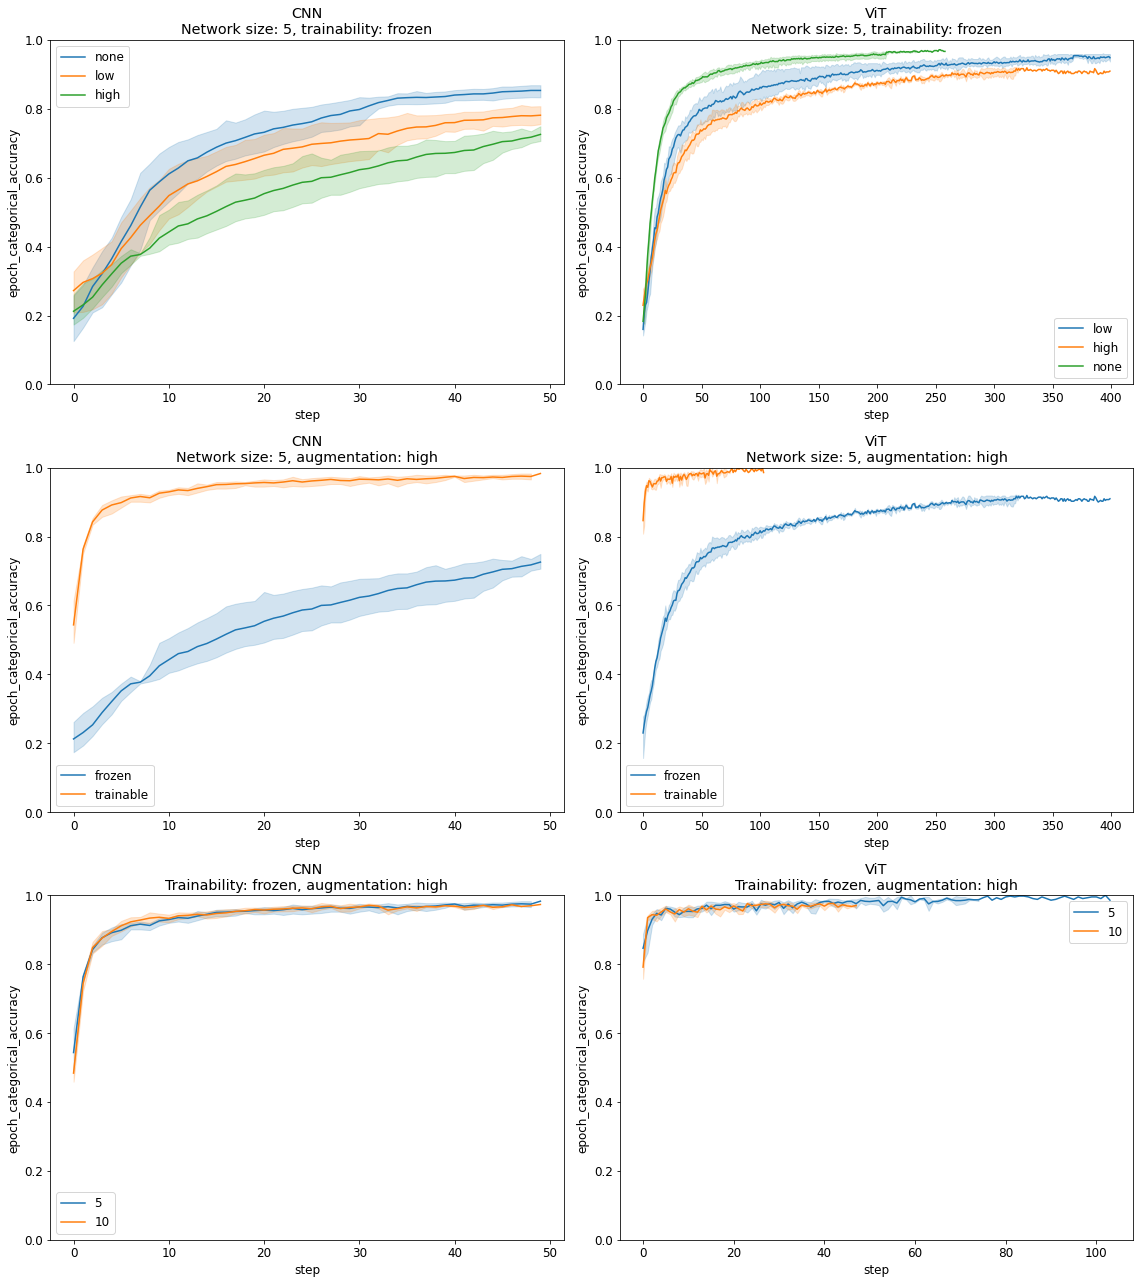

In [38]:
plot_metric_during_training(dfw_validation, "categorical_accuracy")

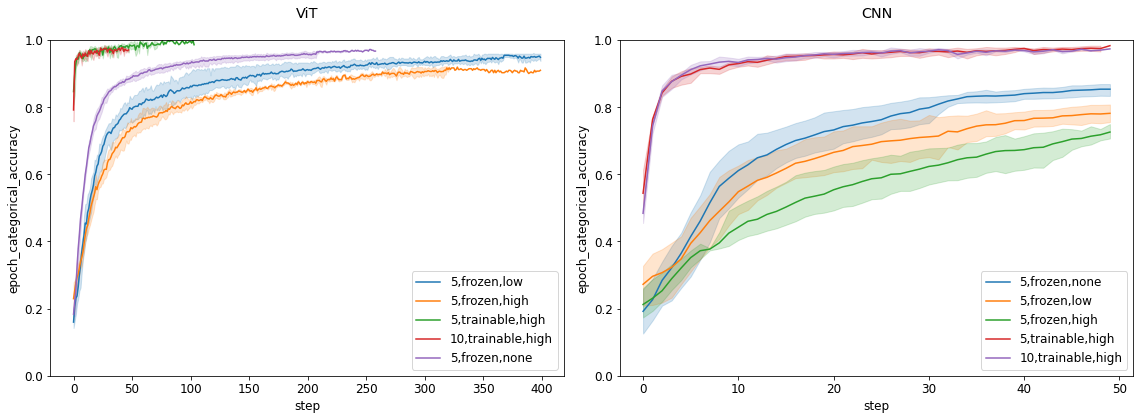

In [39]:
plot_overall(dfw_validation)

### Categorical accuracy during training

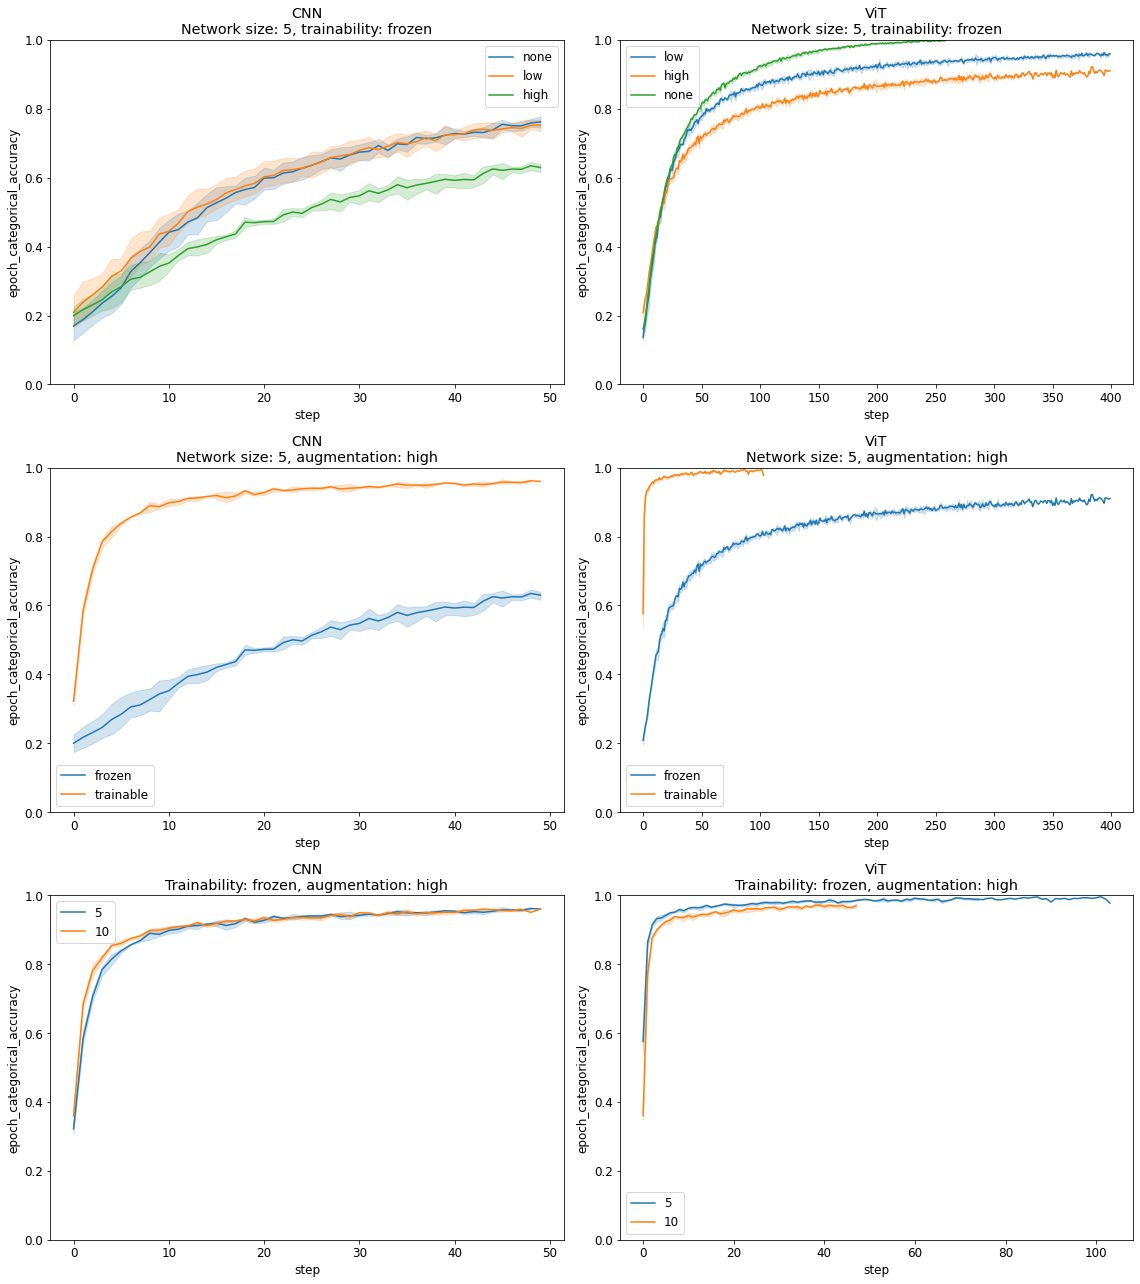

In [40]:
plot_metric_during_training(dfw_training, "categorical_accuracy")

### Loss during training

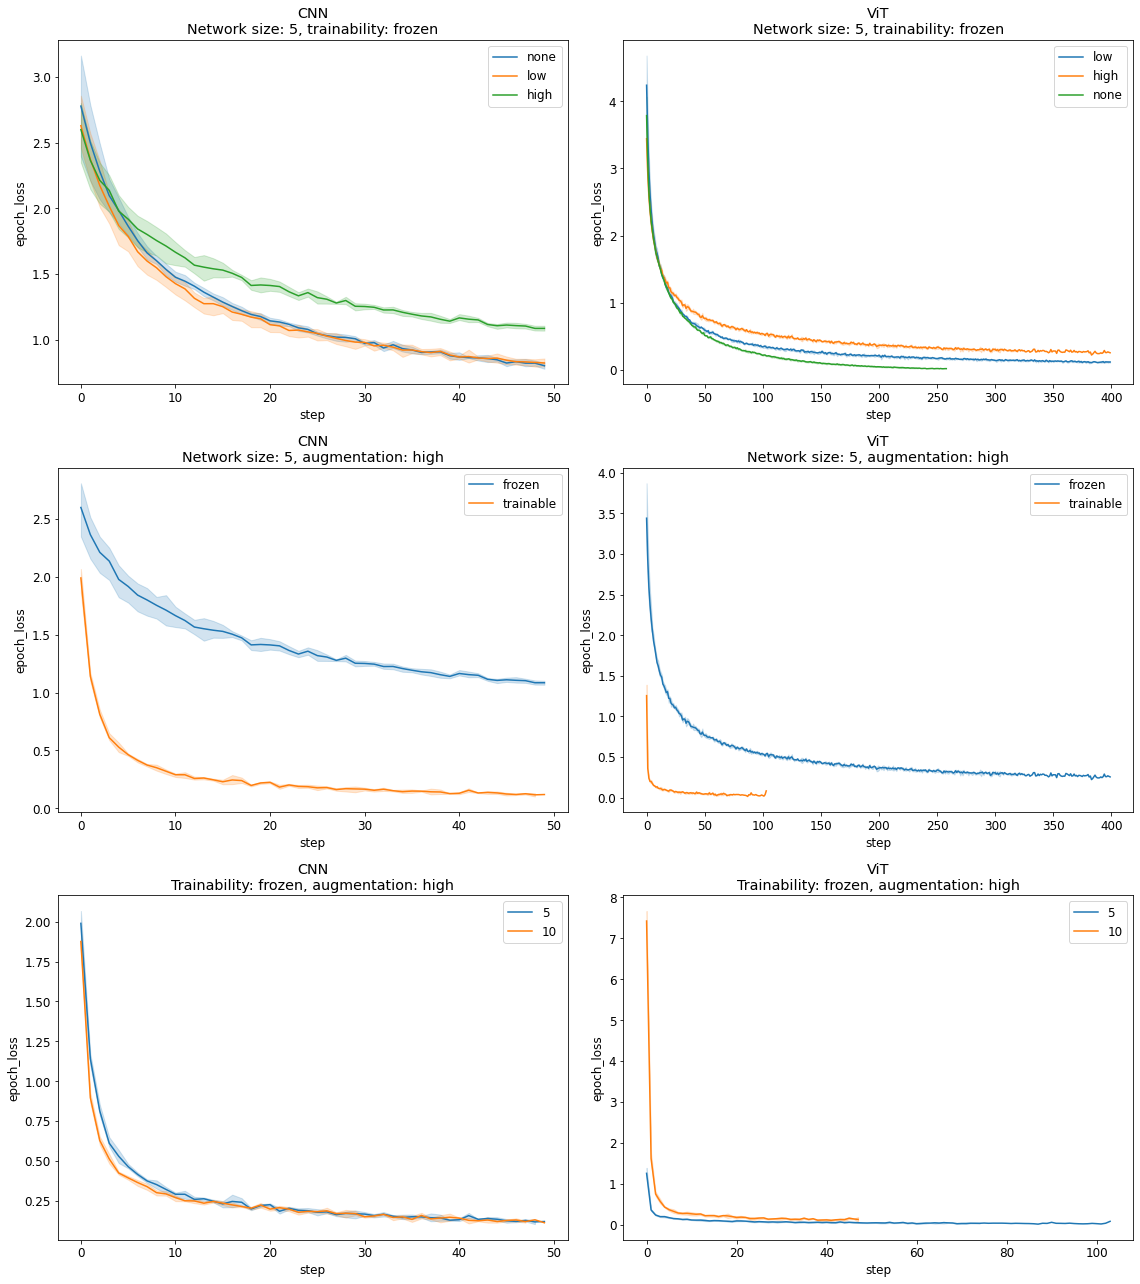

In [41]:
plot_metric_during_training(dfw_training, "loss")

### Loss during validation

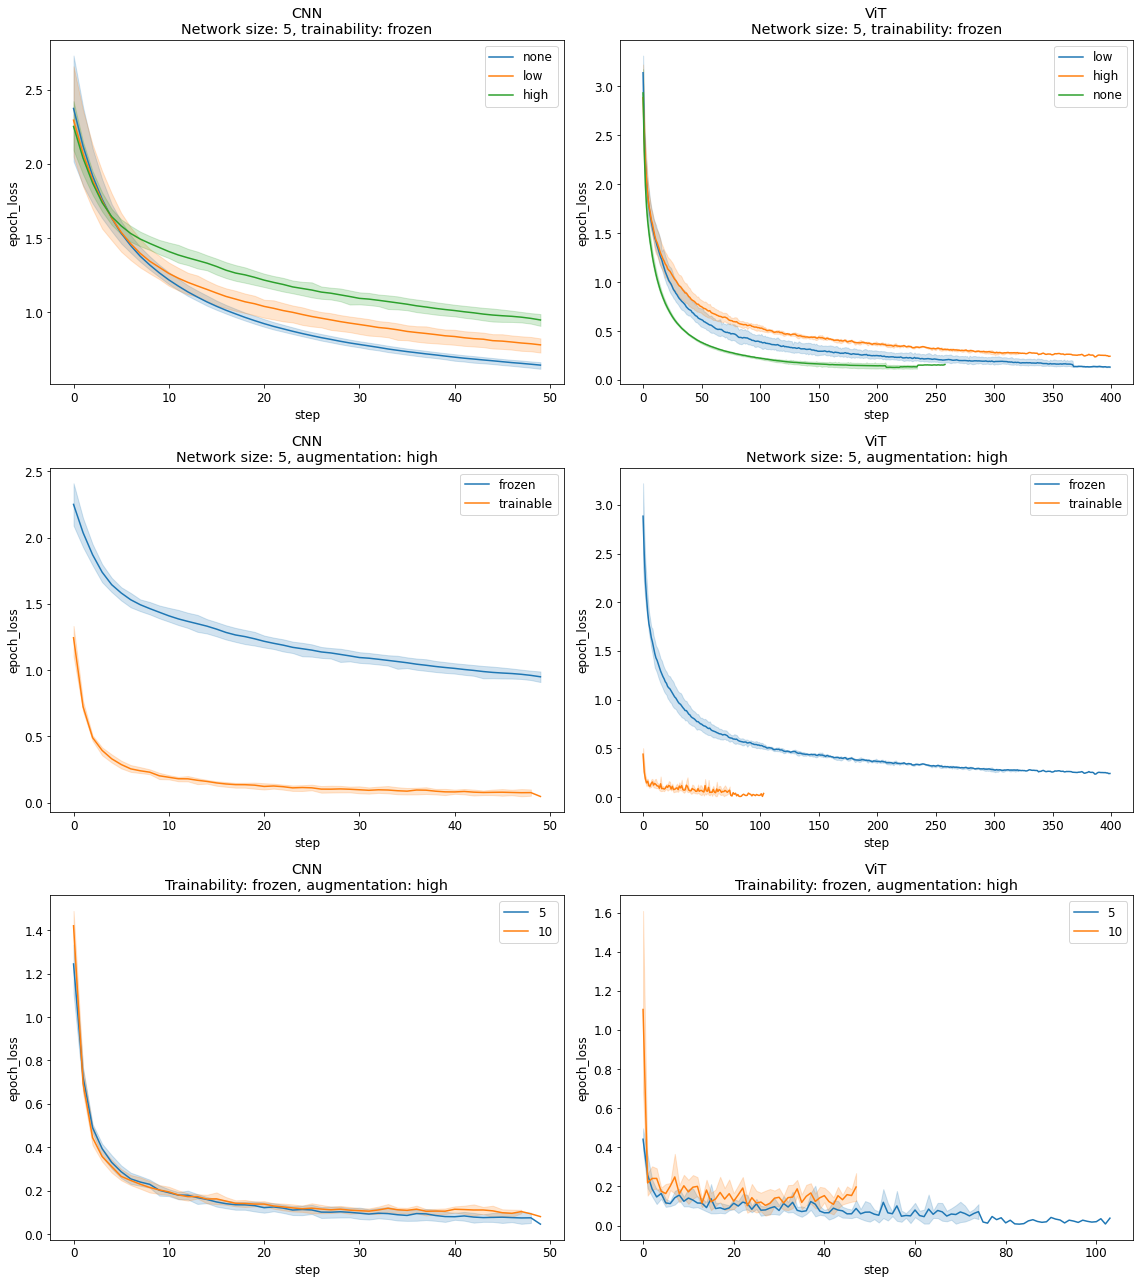

In [42]:
plot_metric_during_training(dfw_validation, "loss")

### Compare the variability of top accuracy and loss for different CNN and ViT models

In [43]:
def plot_boxplot_comparison(data_frame, metric="loss"):
  plt.figure(figsize=(16, 18))

  aggregation = "min" if metric == "loss" else "max"

  for i in range(1, 7):
    data, attribute, attribute_type, title = get_data_and_attribute(data_frame, network_type[i%2].lower(), (i-1)//2+1)
    
    if data.empty:
      continue

    concat = pd.DataFrame(columns=["run", f"epoch_{metric}", attribute_type.name])
    for attribute_value in attribute_type.domain.values:
      selected = data.loc[attribute==f"{attribute_value}", :].groupby(
          "run", as_index=False).agg({f"epoch_{metric}": aggregation})
      selected[attribute_type.name] = attribute_value
      concat = pd.concat([concat, selected])

    if concat.empty:
      continue

    plt.subplot(3, 2, i)
    sns.boxplot(data=concat, y=f"epoch_{metric}", x=attribute_type.name).set_title(f"{network_type[i%2]}_{title}")


def plot_boxplot_overall(data_frame, metric):
    plt.figure(figsize=(16, 20))

    aggregation = "min" if metric == "loss" else "max"

    for i, nt in enumerate(network_type, 1):
      data, attribute, _, title = get_data_and_attribute(data_frame, nt.lower(), 4)
    
      if data.empty:
        continue

      concat = pd.DataFrame(columns=["run", f"epoch_{metric}", "network model"])
      for attribute_value in np.unique(attribute):
        selected = data.loc[np.array(attribute) == f"{attribute_value}", :].groupby(
          "run", as_index=False).agg({f"epoch_{metric}": aggregation})
        selected["model"] = attribute_value
        concat = pd.concat([concat, selected])

      if concat.empty:
        continue

      ax = plt.subplot(3, 2, i)
      sns.boxplot(data=concat, y=f"epoch_{metric}", x="model").set_title(f"{nt}")
      
      if metric == "loss":
        ax.set(ylim=[0,1])
      else:
        ax.set(ylim=[0.7,1])
      for label in ax.get_xmajorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")
        label.set_verticalalignment("top")

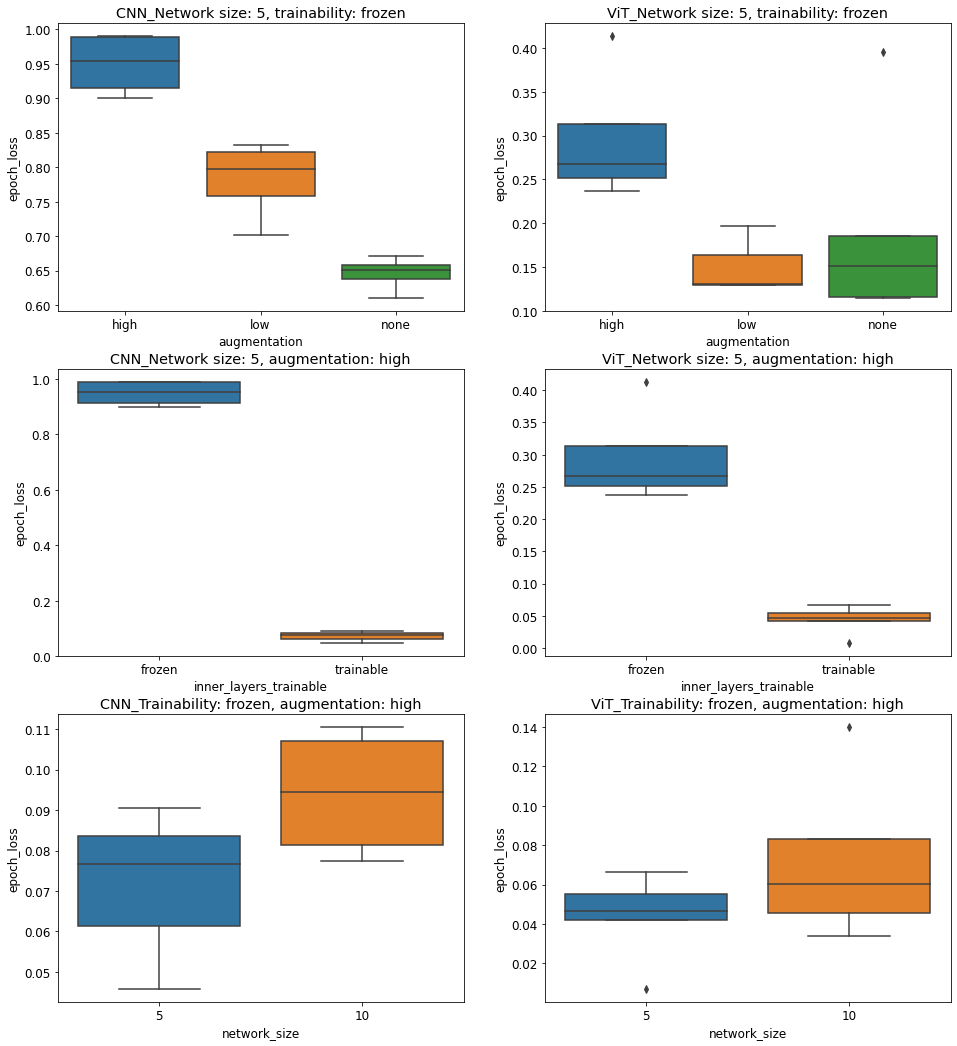

In [44]:
plot_boxplot_comparison(dfw_validation)

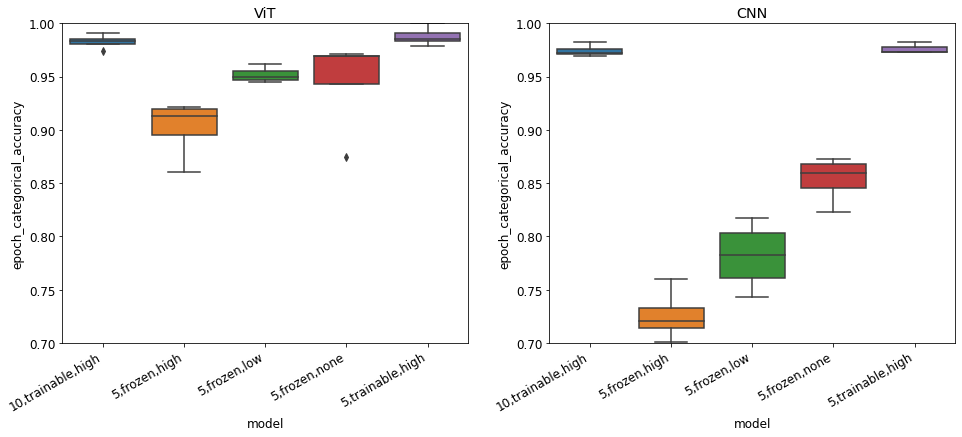

In [45]:
plot_boxplot_overall(dfw_validation, "categorical_accuracy")

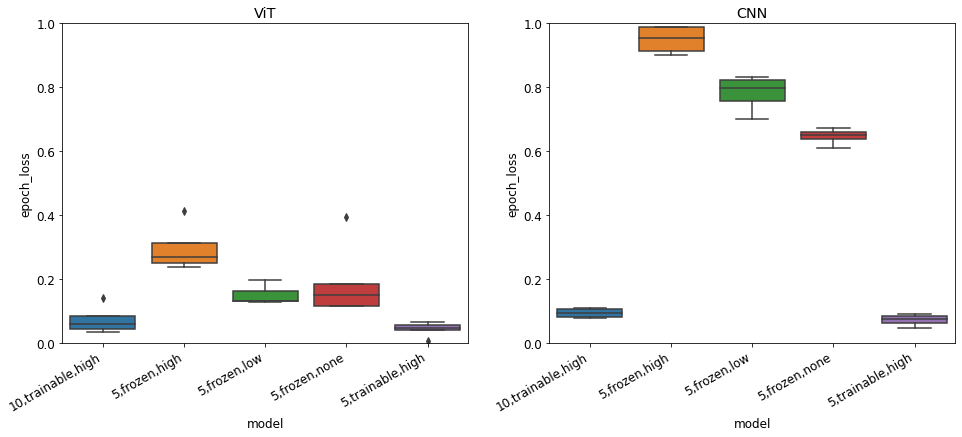

In [46]:
plot_boxplot_overall(dfw_validation, "loss")

### Compare top accuracy and loss for the various CNN and ViT models

In [47]:
def plot_barplot_comparison(data_frame, metric="loss"):
    plt.figure(figsize=(8, 18))
    
    aggregation = "min" if metric == "loss" else "max"

    for i in range(1, 4):
      concat = pd.DataFrame(columns=["run", f"epoch_{metric}", "network_type"])
      for nt in network_type:
        data, attribute, attribute_type, title = get_data_and_attribute(data_frame, nt.lower(), i)
        if concat.empty:
          concat[attribute_type.name] = ""
        for attribute_value in attribute_type.domain.values:
          selected = data.loc[attribute==f"{attribute_value}", :].groupby(
              "run", as_index=False).agg({f"epoch_{metric}": aggregation})
          selected["network_type"] = nt
          selected[attribute_type.name] = attribute_value
          concat = pd.concat([concat, selected])

      if concat.empty:
        continue

      plt.subplot(3, 1, i)
      sns.barplot(x='network_type', y=f'epoch_{metric}', hue=attribute_type.name, 
                  data = concat, errwidth=2).set_title(f"{title}")

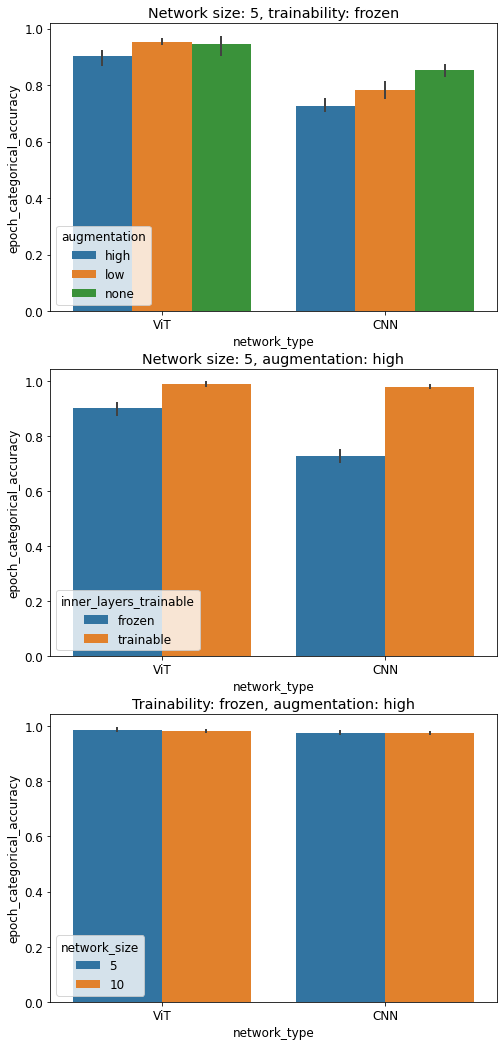

In [48]:
plot_barplot_comparison(dfw_validation, "categorical_accuracy")

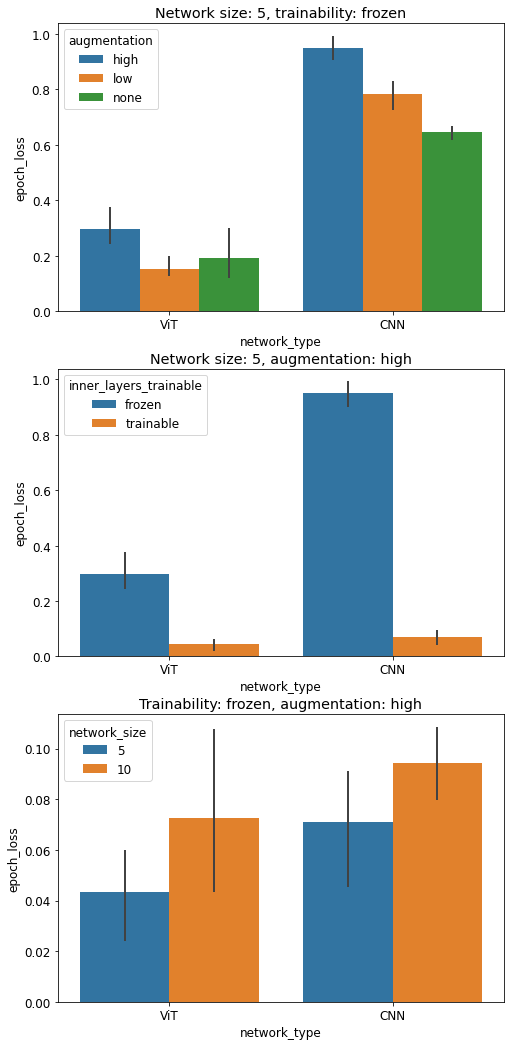

In [49]:
plot_barplot_comparison(dfw_validation, "loss")

### Compare the performance of the models using an independent test set

In [50]:
# Calculates the confusion matrix of a given dataset
def calc_confusion_matrix(model, test_set):
  y_test=[]
  y_prediction = []
  # iterate over the set
  for image, label in test_set:
    # append true labels
    y_test.append(label)
    # compute predictions
    preds = model.predict(image, verbose=0)
    y_prediction.append(preds)

  # Convert the true and predicted labels into tensors
  correct_labels = tf.concat([np.argmax(item, axis=-1) for item in y_test], axis = 0)
  predicted_labels = tf.concat([np.argmax(item, axis=-1) for item in y_prediction], axis = 0)
  # Create confusion matrix and normalizes it over predicted (columns)
  return tf.math.confusion_matrix(correct_labels, predicted_labels)


# By-row normalization
def print_confusion_matrix(ax, confusion_matrix, title):
  row_sums = confusion_matrix.sum(axis=1)
  confusion_matrix = confusion_matrix / row_sums[:, np.newaxis]
  sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True,fmt='.2%', cmap='Blues', ax=ax)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(class_names)
  ax.yaxis.set_ticklabels(class_names)
  ax.set_title(title)
  for label in ax.get_xmajorticklabels() + ax.get_ymajorticklabels():
      label.set_rotation(30)
      label.set_horizontalalignment("right")
      label.set_verticalalignment("top")
  return ax

In [55]:
# Select the model with the best accuracy from the 5 runs
def get_best_model_run(hparams):
  augmentation, size, trainability, network_type, _ = get_attributes(dfw_validation)
  data_frame = dfw_validation[(network_type == hparams[HP_NETWORK_TYPE]) &
                            (size == f"{hparams[HP_NETWORK_SIZE]}") & 
                            (trainability == hparams[HP_INNER_LAYERS_TRAINABLE]) &
                            (augmentation == hparams[HP_AUGMENTATION])]
  best_model = data_frame.epoch_loss.idxmin()[0].split(",")[0]
  return best_model, data_frame


# Loads the best model of a type from disk
def load_best_model(model_type):
  hparams = model_hyperparams[model_type]
  best_model, run_data = get_best_model_run(hparams)
  weight_path = join(log_dir, f"{best_model},{hparams[HP_NETWORK_TYPE]},{hparams[HP_NETWORK_SIZE]},{hparams[HP_INNER_LAYERS_TRAINABLE]},{hparams[HP_AUGMENTATION]}", "model_checkpoint.h5")
  model = build_model(model_type)
  model.load_weights(weight_path)
  return model, run_data

### Load the independent test set

The test set was manually collected and sorted using online cloud images and own photos.

In [52]:
test_location = "drive/MyDrive/test_data"

test_set = tf.keras.utils.image_dataset_from_directory(
    test_location,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=IMAGE_SHAPE,
    shuffle=False
)

Found 163 files belonging to 6 classes.


In [53]:
def plot_confusion_matrix_comparison():
  models = ["5m_la_f", "5m_na_f", "5m_ha_f", "5m_ha_t", "10m_ha_t"]

  fig, axs = plt.subplots(len(models), 2, figsize=(20, 10*len(models)), constrained_layout=True)
  fig.tight_layout(pad=14)

  evaluation_results = pd.DataFrame(columns=["model", "accuracy", "loss"])

  i = 0
  for m in models:
    for nt in network_type:
      model_type = f"{nt.lower()}_{m}"
      model, _ = load_best_model(model_type)      
      fig.axes[i] = print_confusion_matrix(fig.axes[i], calc_confusion_matrix(model, test_set).numpy(), model_type)
      loss, acc = model.evaluate(test_set)
      evaluation_results = evaluation_results.append({"model": model_type, "accuracy": acc, "loss": loss}, ignore_index=True)
      i += 1

  fig.show()
  return evaluation_results

In [ ]:
eval_results = plot_confusion_matrix_comparison()

3/3 [==============================] - 12s 3s/step - loss: 2.5579 - categorical_accuracy: 0.5031


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b1_aa-ea7a6ee0.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b1_aa-ea7a6ee0.pth



#### Compare parameters using the test set

In [ ]:
# Sort and show resulting values
eval_results.set_index("model", inplace=True)
eval_results.sort_values(by="accuracy", ascending=False)

### Compare overall attributes of each model

In [ ]:
from keras_flops import get_flops
from tensorflow.python import train
from keras import backend as K


def get_model_param_count(model):
  trainable_count = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
  non_trainable_count = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
  return int(trainable_count+non_trainable_count)


def get_best_epoch(run_data):
  return run_data.epoch_categorical_accuracy.idxmax()[1]


def get_top_accuracy(run_data):
  return run_data.epoch_categorical_accuracy.max()


def get_best_loss(run_data):
  return run_data.loc[run_data.epoch_categorical_accuracy.idxmax(), "epoch_loss"]


def save_model_info(model_type, model_parameters):
  model, run_data = load_best_model(model_type)
  flops = get_flops(model, batch_size=batch_size)/ 1e9
  param_count = get_model_param_count(model)
  epochs = get_best_epoch(run_data)
  top_accuracy = get_top_accuracy(run_data)
  best_loss = get_best_loss(run_data)
  return model_parameters.append({"Model":model_type, 
                                  "FLOPS (gigaFLOPS)": flops,
                                  "Parameter count": param_count,
                                  "Top accuracy": top_accuracy,
                                  "Loss (top accuracy run)": best_loss, 
                                  "Epochs (top accuracy run)":epochs,
                                  }, ignore_index=True)

In [ ]:
models = ["vit_5m_na_f", "vit_5m_ha_f", "vit_5m_la_f", "vit_5m_ha_t", "vit_10m_ha_t",
          "cnn_5m_na_f", "cnn_5m_la_f", "cnn_5m_ha_f", "cnn_5m_ha_t", "cnn_10m_ha_t"]
model_parameters = DataFrame(columns=["Model", "FLOPS (gigaFLOPS)", "Parameter count",
                                  "Top accuracy", "Loss (top accuracy run)", 
                                  "Epochs (top accuracy run)"])

for model_type in models:
  model_parameters = save_model_info(model_type, model_parameters)

model_parameters.set_index("Model", inplace=True)
model_parameters.sort_values(by="Top accuracy", inplace=True, ascending=False)

In [ ]:
model_parameters

#### Check a couple of classifications

In [ ]:
import matplotlib.pyplot as plt

def show_classifications(model, image_set, labels, n_pred_lables_to_show=2, difference_with_red=False):
  # Check out a few classifications
  plt.figure(figsize=(15, 15))
  for images, actual_labels in image_set.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      im = images[i].numpy()
      plt.imshow(im.astype("uint8"))

      actual_label = class_names[np.argmax(actual_labels[i])]
      print(f"Actual label: {actual_label}")

      # Print the first n strongest classifications
      predictions = model.predict(tf.expand_dims(im, 0).numpy(), verbose=0)
      ind = np.argpartition(predictions, -n_pred_lables_to_show)[..., -n_pred_lables_to_show:]
      ind.reshape((1, -1))
      predicted_labels = labels[ind[:].astype(int)]
      print(f"Inferred labels: {predicted_labels[0]}")
      print("\n")

      color = 'black'
      if difference_with_red and predicted_labels[0, 0] != actual_label:
        color = 'red'
      plt.title(f"Class: {actual_label}\nPrediction: {predicted_labels[0, 0]}", color=color)
      plt.axis("off")

In [ ]:
model = load_best_model("vit_10m_ha_t")
show_classifications(model, test_set, class_names, n_pred_lables_to_show=1, difference_with_red=True)